# Raisin Class Classification using Dense Layers

In [136]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [137]:
torch.manual_seed(42)
np.random.seed(42)

In [138]:
data = pd.read_excel('data/Raisin_Dataset.xlsx')
X = data.drop('Class', axis=1).values
y = data['Class'].map({'Kecimen': 0, 'Besni': 1}).values

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [140]:
class RaisinDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RaisinDataset(X_train, y_train)
val_dataset = RaisinDataset(X_val, y_val)
test_dataset = RaisinDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [141]:
class RaisinNet(nn.Module):
    def __init__(self, input_size):
        super(RaisinNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.fc4 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [142]:
net = RaisinNet(X_train.shape[1])
print(net)

RaisinNet(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [143]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [144]:
num_epochs = 250
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = net(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/250], Train Accuracy: 0.8000, Validation Accuracy: 0.7444
Epoch [20/250], Train Accuracy: 0.8083, Validation Accuracy: 0.8222
Epoch [30/250], Train Accuracy: 0.8250, Validation Accuracy: 0.8444
Epoch [40/250], Train Accuracy: 0.8694, Validation Accuracy: 0.8333
Epoch [50/250], Train Accuracy: 0.8472, Validation Accuracy: 0.8333
Epoch [60/250], Train Accuracy: 0.8278, Validation Accuracy: 0.8222
Epoch [70/250], Train Accuracy: 0.8556, Validation Accuracy: 0.8111
Epoch [80/250], Train Accuracy: 0.8528, Validation Accuracy: 0.8111
Epoch [90/250], Train Accuracy: 0.8556, Validation Accuracy: 0.8111
Epoch [100/250], Train Accuracy: 0.8528, Validation Accuracy: 0.8111
Epoch [110/250], Train Accuracy: 0.8472, Validation Accuracy: 0.8111
Epoch [120/250], Train Accuracy: 0.8306, Validation Accuracy: 0.8111
Epoch [130/250], Train Accuracy: 0.8639, Validation Accuracy: 0.8111
Epoch [140/250], Train Accuracy: 0.8500, Validation Accuracy: 0.8111
Epoch [150/250], Train Accuracy: 0.8500, Va

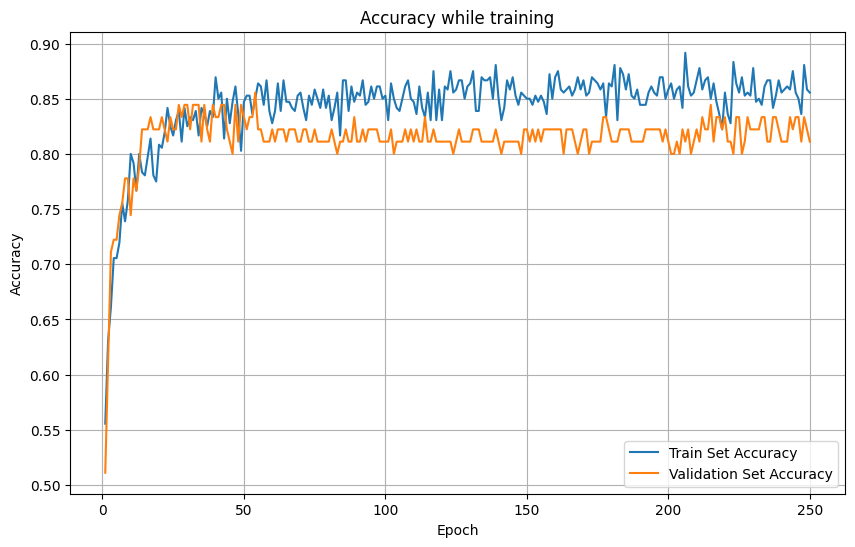

In [145]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [146]:
net.eval()
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

In [147]:
print('Test Accuracy:')
print(accuracy_score(y_true, y_pred))
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=['Kecimen', 'Besni']))
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))

Test Accuracy:
0.8511111111111112
Classification Report:
              precision    recall  f1-score   support

     Kecimen       0.85      0.88      0.86       237
       Besni       0.86      0.82      0.84       213

    accuracy                           0.85       450
   macro avg       0.85      0.85      0.85       450
weighted avg       0.85      0.85      0.85       450

Confusion Matrix:
[[208  29]
 [ 38 175]]
